## Imports
---

In [1]:
from model.model import CNet2D
from model.dataloader import NearlabDatasetLoader, NinaproDatasetLoader
from model.utils import list_files
import scipy.io
import numpy as np
import pandas as pd

In [2]:
path_nearlab = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/data/nearlab/8features/person1"
version="GMLVQ"
file_paths_nearlab = list_files(path_nearlab, "csv")

In [6]:
path_ninapro = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/data/ninapro/DB2/person1"
version="GMLVQ"
file_paths_ninapro = list_files(path_ninapro, "mat")

In [ ]:
ninapro = NinaproDatasetLoader(file_paths_ninapro[:2], file_paths_ninapro[2:])

X_train, y_train, X_test, y_test = ninapro.load_data()

In [3]:
nearlab = NearlabDatasetLoader(file_paths_nearlab[:2], file_paths_nearlab[2:])
X_train, y_train, X_test, y_test = nearlab.load_data()
model = CNet2D(version, epochs=3)
model.fit(X_train, y_train)

Batch Accuracy: 0.6328
d1 mean: 20.5208, d2 mean: 21.0210
Batch Loss (GLVQ/GMLVQ): 0.4973
Batch Accuracy: 0.1562
d1 mean: 22.2254, d2 mean: 19.7179
Batch Loss (GLVQ/GMLVQ): 0.5149
Batch Accuracy: 0.3125
d1 mean: 21.9160, d2 mean: 19.7748
Batch Loss (GLVQ/GMLVQ): 0.5122
Batch Accuracy: 0.3281
d1 mean: 21.7377, d2 mean: 19.9659
Batch Loss (GLVQ/GMLVQ): 0.5102
Batch Accuracy: 0.2500
d1 mean: 21.0877, d2 mean: 19.4095
Batch Loss (GLVQ/GMLVQ): 0.5110
Batch Accuracy: 0.3750
d1 mean: 21.0541, d2 mean: 20.0987
Batch Loss (GLVQ/GMLVQ): 0.5073
Batch Accuracy: 0.4219
d1 mean: 21.4163, d2 mean: 20.5436
Batch Loss (GLVQ/GMLVQ): 0.5062
Batch Accuracy: 0.4297
d1 mean: 20.9522, d2 mean: 20.7737
Batch Loss (GLVQ/GMLVQ): 0.5035
Batch Accuracy: 0.5234
d1 mean: 20.4627, d2 mean: 20.7515
Batch Loss (GLVQ/GMLVQ): 0.5001
Batch Accuracy: 0.5156
d1 mean: 20.9216, d2 mean: 21.2811
Batch Loss (GLVQ/GMLVQ): 0.4991
Batch Accuracy: 0.5156
d1 mean: 20.5901, d2 mean: 21.1158
Batch Loss (GLVQ/GMLVQ): 0.4985
Batch Accu

KeyboardInterrupt: 

Test Accuracy: 0.7648


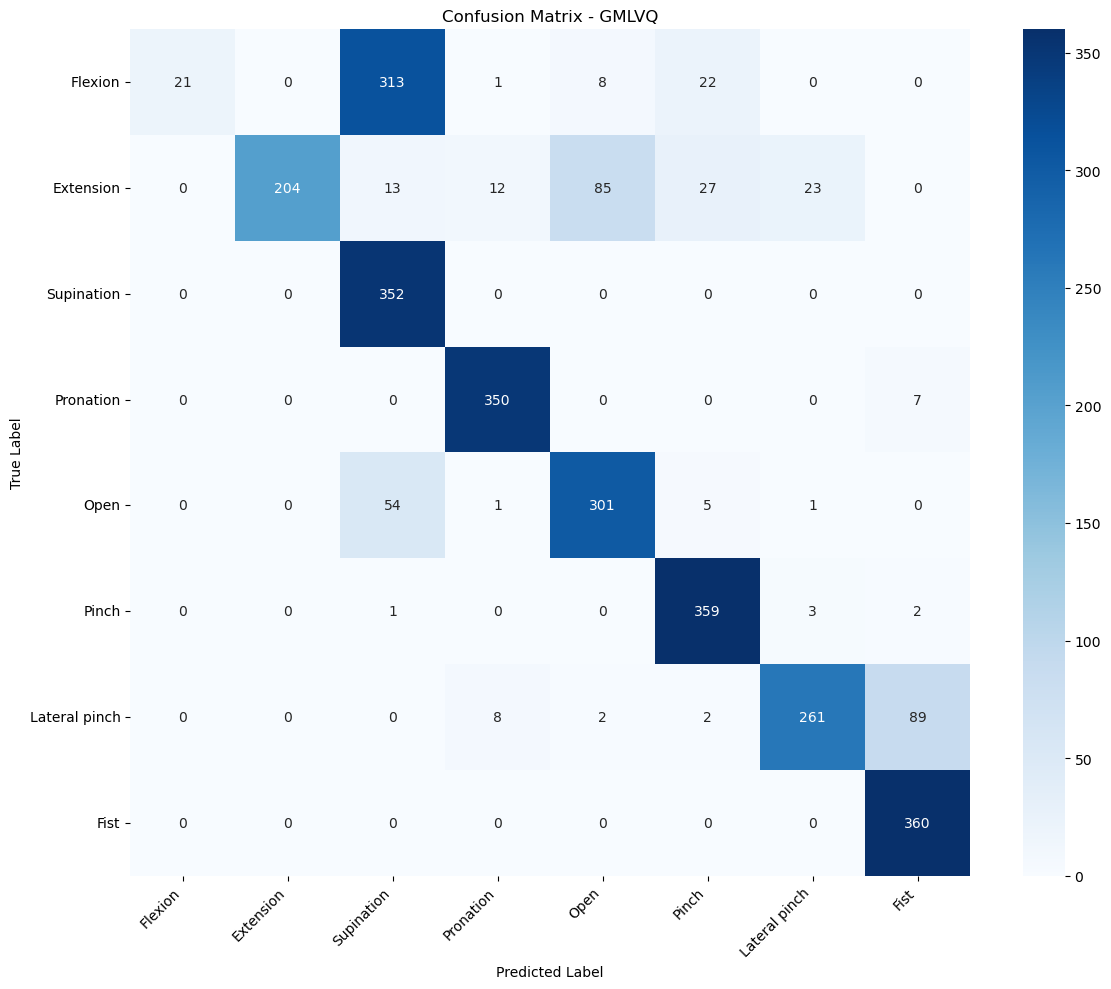


Classification Report:
               precision    recall  f1-score   support

      Flexion       1.00      0.06      0.11       365
    Extension       1.00      0.56      0.72       364
   Supination       0.48      1.00      0.65       352
    Pronation       0.94      0.98      0.96       357
         Open       0.76      0.83      0.79       362
        Pinch       0.87      0.98      0.92       365
Lateral pinch       0.91      0.72      0.80       362
         Fist       0.79      1.00      0.88       360

     accuracy                           0.76      2887
    macro avg       0.84      0.77      0.73      2887
 weighted avg       0.84      0.76      0.73      2887


Per-class Accuracy:
Flexion: 0.0575
Extension: 0.5604
Supination: 1.0000
Pronation: 0.9804
Open: 0.8315
Pinch: 0.9836
Lateral pinch: 0.7210
Fist: 1.0000


{'accuracy': 0.7648077607154846,
 'confusion_matrix': array([[ 21,   0, 313,   1,   8,  22,   0,   0],
        [  0, 204,  13,  12,  85,  27,  23,   0],
        [  0,   0, 352,   0,   0,   0,   0,   0],
        [  0,   0,   0, 350,   0,   0,   0,   7],
        [  0,   0,  54,   1, 301,   5,   1,   0],
        [  0,   0,   1,   0,   0, 359,   3,   2],
        [  0,   0,   0,   8,   2,   2, 261,  89],
        [  0,   0,   0,   0,   0,   0,   0, 360]]),
 'per_class_accuracy': array([0.05753425, 0.56043956, 1.        , 0.98039216, 0.83149171,
        0.98356164, 0.72099448, 1.        ]),
 'predictions': array([5, 5, 3, ..., 2, 6, 1]),
 'true_labels': array([5, 5, 3, ..., 4, 4, 1])}

In [3]:
model.evaluate_model(X_test, y_test)


# Evaluation
---

# What i want to evaluate

1. Accuracy overview GLVQ, GMLVQ and Softmax
    - Also keep into account which model is being used
    - Compare to standard Machine learning methods
2. Compare different number of prototypes
    - Run the algorithm for GLVQ and GMLVQ for different numbers of the prototypes and plot the difference between number and accuracy
3. Something with few-shot learning
4. Compare Confusion matrices to see where each model has its trouble
5. Graph of the accuracy per subject
6. Plot of the loss function how it decreases over each epoch
7. Plot of the model accracy
8. Table with each Layer with the following values:
    1. Average Accuracy
    2. Std
    3. Median
    4. Highest and lowest value

### 1. Accuracy with 50 epochs on each model + Plot of loss and acc

In [ ]:
model = ["Softmax", "GLVQ", "GMLVQ"]

path_results = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/results/nearlab/basicEval"
path_data = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/data/nearlab/8features"

for i in range(1,12):
    file_paths_nearlab = list_files(path_data + "/person" + str(i), "csv")
    nearlab = NearlabDatasetLoader(file_paths_nearlab[:2], file_paths_nearlab[2:])
    X_train, y_train, X_test, y_test = nearlab.load_data()
    for m in model:
        current_model = CNet2D(version=m, epochs=50)
        current_model.fit(X_train, y_train)
        current_model.save_model(path_results + "/person" + str(i) + "/" + m + ".h5")


### Playing around with GLVQ num of prototypes

In [ ]:
prototypes_per_class = [1, 2, 3, 4, 7]  


model = ["GLVQ", "GMLVQ"]

path_results = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/results/nearlab/numPrototypes"
path_data = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/data/nearlab/8features"

for i in range(1,12):
    for prot in prototypes_per_class:
        file_paths_nearlab = list_files(path_data + "/person" + str(i), "csv")
        nearlab = NearlabDatasetLoader(file_paths_nearlab[:2], file_paths_nearlab[2:])
        X_train, y_train, X_test, y_test = nearlab.load_data()
        for m in model:
            current_model = CNet2D(version=m, epochs=10)
            current_model.fit(X_train, y_train)
            current_model.save_model(path_results + "/person" + str(i) + "/" + m + "_num_" +str(prot) + ".h5")

## FSL - 